In [ ]:
from load_modules import *
import my_config
import time
# K.clear_session()
# os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

In [47]:
if my_config.USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU')
    #set memory amount to half of GPU
    if len(physical_devices) > 0:
        for device in physical_devices:
            print("Device:", device)
    else:
        print("No GPU devices found.")
    # Set GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
        except RuntimeError as e:
            print(e)
        # Set environment variable for GPU memory allocation
    os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
    # Test for GPU device name
    name = tf.test.gpu_device_name()
    if name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(name))
    # Print the number of available GPUs
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU")

Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found GPU at: /device:GPU:0
Num GPUs Available:  1


In [48]:
image_paths = os.listdir(my_config.IMAGE_FOLDER)
images = []
names = []
for image_path in image_paths:
    folder_name = image_path.split('.')[0]
    names.append(folder_name)
    image_path = os.path.join(my_config.IMAGE_FOLDER, image_path)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    if np.max(image) > 1:
        image = image/255.0
    images.append(image)
print(names)
all_model_paths = []
print(my_config.IMAGE_FOLDER)
print(my_config.ENCODER_PATH)
print(my_config.DECODER_PATH)

encoder = load_model(my_config.ENCODER_PATH)
decoder = load_model(my_config.DECODER_PATH)
print("Loaded models")
print("Encoder summary:" + str(encoder.summary()))
print("Decoder summary:" + str(decoder.summary()))
def encode(img):
    image = np.asarray(img).reshape(-1,3).astype('float32')
    # pred_maps = encoder.predict(image)
    start = time.time()
    pred_maps = None
    with tf.device('/device:GPU:0'):
        pred_maps = encoder.predict_on_batch(image)
    end = time.time()
    elapsed = end - start
    return pred_maps, elapsed
 
def decode(encoded):
    # recovered = decoder.predict(encoded)
    start = time.time()
    recovered = None
    with tf.device('/device:GPU:0'):
        recovered = decoder.predict_on_batch(encoded)
    end = time.time()
    elapsed = end - start
    # recovered = np.clip(recovered, 0, 1)
    return recovered, elapsed
def calculate_deltaE(original, recovered):  # assuming this function is defined
    WIDTH = original.shape[0]
    HEIGHT = original.shape[1]
    # Convert the images to the CAM02-UCS color space and calculate the delta E loss
    if original.shape[0] != recovered.shape[0] or original.shape[1] != recovered.shape[1]:
        print("original shape:", original.shape)
        print("recovered shape:", recovered.shape)
        print("original and recovered shape do not match")
        original = original.reshape((WIDTH, HEIGHT, 3))
        recovered = recovered.reshape((WIDTH, HEIGHT, 3))
    original_lab = colorspacious.cspace_convert(np.array(original), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    recovered_lab = colorspacious.cspace_convert(np.array(recovered), 'sRGB1', 'CAM02-UCS').reshape((WIDTH,HEIGHT,3))
    delta_e = np.sqrt(np.sum((original_lab - recovered_lab)**2, axis=2))
    # Plot the delta E loss in the third subplot
    return delta_e

['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
models_4k
TrainedModels\316\encoder.h5
TrainedModels\316\decoder.h5
Loaded models
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 3)]               0         
_________________________________________________________________
encoder_dense_0 (Dense)      (None, 75)                300       
_________________________________________________________________
encoder_dense_2 (Dense)      (None, 75)                5700      
_________________________________________________________________
encoder_output (Dense)       (None, 5)                 380       
Total params: 6,380
Trainable params: 6,380
Non-trainable params: 0
_________________________________________________________________
Encoder summary:None
Model: "decoder"
_________________________________________________________________
Layer (type)     

shape of pred_maps: (16777216, 5)
Cm min: -0.12028490006923676 Cm mean: -0.03946948051452637| Cm max: 0.6048144698143005 | Ch min: 0.019787704572081566 Ch mean: 0.07272251695394516| Ch max: 0.26484233140945435 | T min: 0.11883066594600677 T mean: 0.25354212522506714| T max: 0.2948184907436371 | Bm min: 0.43725767731666565 Bm mean: 0.46727296710014343| Bm max: 0.5214803814888 | Bh min: 0.3536691665649414 Bh mean: 0.4931521713733673| Bh max: 0.7057251930236816
shape of recovered: (16777216, 3)


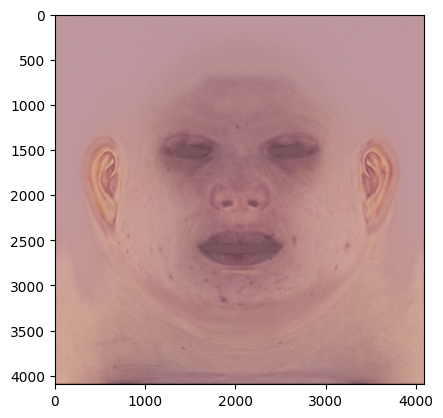

size of image: (4096, 4096, 3)
max pixel value: 0.8758367896080017
min pixel value: 0.07937610149383545
shape of pred_maps: (16777216, 5)
Cm min: 0.03346395492553711 Cm mean: 0.1652640849351883| Cm max: 0.6082663536071777 | Ch min: 0.09142030775547028 Ch mean: 0.13961906731128693| Ch max: 0.2608961760997772 | T min: 0.11517101526260376 T mean: 0.20232300460338593| T max: 0.23726987838745117 | Bm min: 0.44760218262672424 Bm mean: 0.46695438027381897| Bm max: 0.5535187125205994 | Bh min: 0.3419257700443268 Bh mean: 0.5366775989532471| Bh max: 0.6923635601997375
shape of recovered: (16777216, 3)


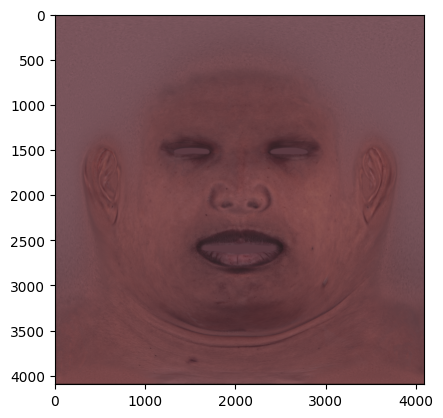

size of image: (4096, 4096, 3)
max pixel value: 0.6304264664649963
min pixel value: 0.07844528555870056
shape of pred_maps: (16777216, 5)
Cm min: -0.06582286953926086 Cm mean: 0.036671195179224014| Cm max: 0.6065523028373718 | Ch min: 0.008222486823797226 Ch mean: 0.08171066641807556| Ch max: 0.2555375099182129 | T min: 0.1176396980881691 T mean: 0.24842029809951782| T max: 0.30809617042541504 | Bm min: 0.43843263387680054 Bm mean: 0.46171408891677856| Bm max: 0.528731644153595 | Bh min: 0.34928521513938904 Bh mean: 0.5480127334594727| Bh max: 0.7297863960266113
shape of recovered: (16777216, 3)


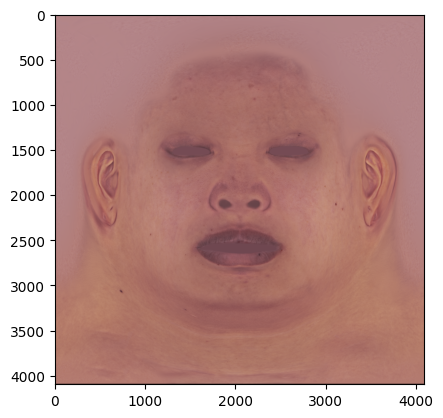

size of image: (4096, 4096, 3)
max pixel value: 0.9096750020980835
min pixel value: 0.07897499948740005
shape of pred_maps: (16777216, 5)
Cm min: -0.01896987482905388 Cm mean: 0.33364251255989075| Cm max: 0.6058636903762817 | Ch min: 0.1135353147983551 Ch mean: 0.19760005176067352| Ch max: 0.2718130350112915 | T min: 0.11883066594600677 T mean: 0.17635725438594818| T max: 0.22258847951889038 | Bm min: 0.45514732599258423 Bm mean: 0.5027567744255066| Bm max: 0.5416877269744873 | Bh min: 0.3536691665649414 Bh mean: 0.5084818005561829| Bh max: 0.6169372797012329
shape of recovered: (16777216, 3)


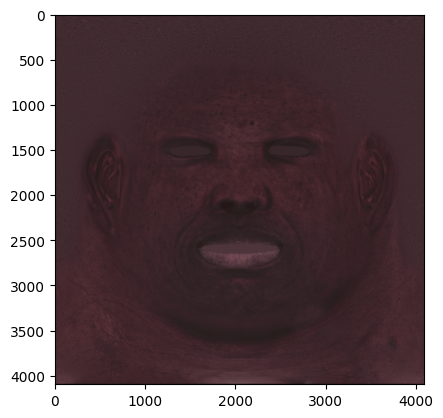

size of image: (4096, 4096, 3)
max pixel value: 0.5954862236976624
min pixel value: 0.07773003727197647
shape of pred_maps: (16777216, 5)
Cm min: 0.01696954295039177 Cm mean: 0.4928639233112335| Cm max: 0.6065523028373718 | Ch min: 0.13491104543209076 Ch mean: 0.25436797738075256| Ch max: 0.27543067932128906 | T min: 0.11792317032814026 T mean: 0.14620478451251984| T max: 0.1932726949453354 | Bm min: 0.4418496787548065 Bm mean: 0.5230086445808411| Bm max: 0.5455474853515625 | Bh min: 0.3323155641555786 Bh mean: 0.4178870618343353| Bh max: 0.534487783908844
shape of recovered: (16777216, 3)


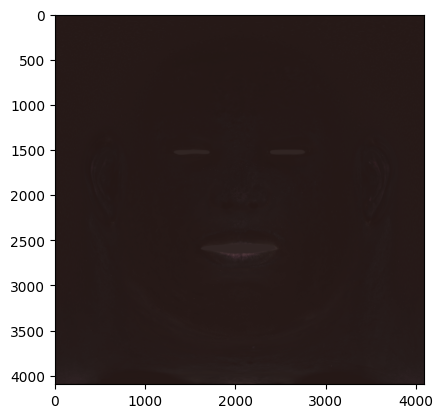

size of image: (4096, 4096, 3)
max pixel value: 0.5230416059494019
min pixel value: 0.07793199270963669


In [49]:
# fig,ax = plt.subplots(5,5, figsize=(16,14))
subjects_meta = ['m141_4k', 'm46_4k', 'm53_4k', 'm64_4k', 'm98_4k']
idx = 0

for image, folder_name in zip(images, names):
    WIDTH = image.shape[0]
    HEIGHT = image.shape[1]
    image = np.asarray(image)
    image_numpy = image.reshape((WIDTH, HEIGHT, 3))
    pred_maps, encode_time = encode(image_numpy)
    print(f"shape of pred_maps: {pred_maps.shape}")
    Cm = np.asarray(pred_maps[:,0])
    Ch = np.asarray(pred_maps[:,1])
    Bm = np.asarray(pred_maps[:,2])
    Bh = np.asarray(pred_maps[:,3])
    T = np.asarray(pred_maps[:,4])
    av_T = np.mean(T)
    max_T = np.max(T)
    min_T = np.min(T)
    av_Cm = np.mean(Cm)
    max_Cm = np.max(Cm)
    min_Cm = np.min(Cm)
    av_Ch = np.mean(Ch)
    max_Ch = np.max(Ch)
    min_Ch = np.min(Ch)
    min_Bm = np.min(Bm)
    max_Bm = np.max(Bm)
    av_Bm = np.mean(Bm)
    min_Bh = np.min(Bh)
    max_Bh = np.max(Bh)
    av_Bh = np.mean(Bh)
    # result_string = f"Cm: {av_Cm}, {max_Cm}, {min_Cm} | Ch: {av_Ch}, {max_Ch}, {min_Ch} | T: {av_T}, {max_T}, {min_T} | delta_e: {av_delta_e}, {max_delta_e}, {min_delta_e}"
    result_string = f"Cm min: {min_Cm} Cm mean: {av_Cm}| Cm max: {max_Cm} | Ch min: {min_Ch} Ch mean: {av_Ch}| Ch max: {max_Ch} | T min: {min_T} T mean: {av_T}| T max: {max_T} | Bm min: {min_Bm} Bm mean: {av_Bm}| Bm max: {max_Bm} | Bh min: {min_Bh} Bh mean: {av_Bh}| Bh max: {max_Bh}"
    print(result_string)
    pred_maps[:,0] = Cm*0.9
    pred_maps[:,1] = Ch*0.9
    pred_maps[:,2] = Bm
    pred_maps[:,3] = Bh*0.8
    pred_maps[:,4] = T*0.8
    recovered, decode_time = decode(pred_maps)
    print(f"shape of recovered: {recovered.shape}")
    recovered = np.asarray(recovered).reshape((WIDTH, HEIGHT, 3))
    # recovered_lab= colorspacious.cspace_convert(recovered, 'sRGB1', 'CAM02-UCS')
    # recovered = np.asarray(decoded_increased_Cm).reshape((WIDTH, HEIGHT, 3))
    plt.imshow(recovered)
    plt.show()
    #save the image 
    #print size of image
    print(f"size of image: {recovered.shape}")
    #max min pixel values
    print(f"max pixel value: {np.max(recovered)}")
    print(f"min pixel value: {np.min(recovered)}")
    #clamp the values to 0-1
    recovered = np.clip(recovered, 0, 1)
    # experiment_name = input("Enter experiment name: ")
    # file_NAME = f"{experiment_name}_{subjects_meta[idx]}.png"
    # plt.imsave(file_NAME, recovered)
    idx += 1
    